<a href="https://colab.research.google.com/github/swilsonmfc/linear/blob/main/Splines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Splines

![](https://sc04.alicdn.com/kf/HTB1v6orba61gK0jSZFlq6xDKFXaA.jpg)

# Install

In [1]:
!pip install pwlf

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.datasets import make_regression
from sklearn.metrics  import mean_squared_error

from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pwlf

from scipy import optimize

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

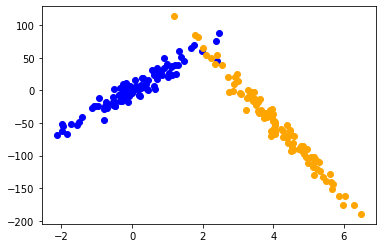

In [3]:
x1, y1 = make_regression(n_features=1, noise=10, random_state=10)
x2, y2 = make_regression(n_features=1, noise=10, random_state=60)
x2 = x2 + 4
y2 = (y2 + 50) * -1

X = pd.DataFrame(np.vstack([x1, x2]))
y = np.concatenate([y1, y2])

plt.scatter(x1, y1, color='blue')
plt.scatter(x2, y2, color='orange')

# Ranged Regression
* Create a dummy variable for each range
* pd.cut will generate bins, but they can be specified
* Downside may not fit well (slopes)

In [4]:
BINS = 4
cut, bins = pd.cut(X[0], BINS, retbins=True)
X_cut = pd.get_dummies(cut)
X_train = pd.concat([X, X_cut], ignore_index=True, axis=1)
X_train.columns = ['X'] + list(X_cut.columns)
X_train

,X,"(-2.14, 0.024]","(0.024, 2.18]","(2.18, 4.335]","(4.335, 6.491]"
0,-1.136602,1,0,0,0
1,-1.418556,1,0,0,0
2,1.744814,0,1,0,0
3,-0.232182,1,0,0,0
4,-0.489337,1,0,0,0
...,...,...,...,...,...
195,3.892859,0,0,1,0
196,2.338194,0,0,1,0
197,5.396275,0,0,0,1
198,4.981274,0,0,0,1


In [5]:
fit = sm.GLM(y, X_train).fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      195
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          887.61
Method:                          IRLS   Log-Likelihood:                -960.11
Date:                Tue, 20 Jul 2021   Deviance:                   1.7308e+05
Time:                        19:51:01   Pearson chi2:                 1.73e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
X                 -9.4663      3.669     -2.

RMSE = 29.42


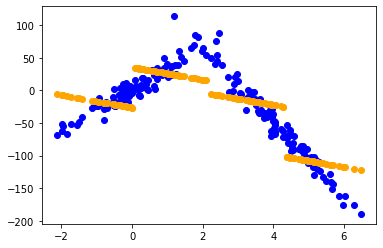

In [6]:
plt.scatter(X_train.X, y, color='blue')
pred = fit.predict(X_train)
plt.scatter(X_train.X, pred, color='orange')
print(f'RMSE = {mean_squared_error(pred, y) ** 0.5:.2f}')

# Split Regression
* Break the space into multiple regression problems
* Have to determine the thresholds / cutoffs
* Each regression can have different properties
* Thresholds could have undesirable properties (not continuous)

In [7]:
THRESHOLD = 3
data_df = pd.concat([X, pd.DataFrame(y)], ignore_index=True, axis=1)
data_df.columns = ['X', 'y']

In [8]:
X_train1 = data_df[data_df.X < THRESHOLD]
X_train2 = data_df[data_df.X >= THRESHOLD]
y_train1 = X_train1.pop('y')
y_train2 = X_train2.pop('y')

In [9]:
lm1 = LinearRegression()
lm1.fit(X_train1, y_train1)
lm2 = LinearRegression()
lm2.fit(X_train2, y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

RMSE = 16.02


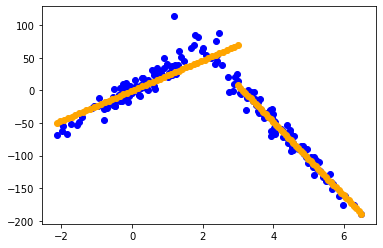

In [10]:
plt.scatter(X_train1, y_train1, color='blue')
plt.scatter(X_train2, y_train2, color='blue')

xplot = np.linspace(X_train1.X.min(), THRESHOLD, 50)
yplot = lm1.predict(pd.DataFrame(xplot))
plt.scatter(xplot, yplot, color='orange')

xplot = np.linspace(THRESHOLD, X_train2.X.max(), 50)
yplot = lm2.predict(pd.DataFrame(xplot))
plt.scatter(xplot, yplot, color='orange')

pred   = np.concatenate([lm1.predict(X_train1), lm2.predict(X_train2)])
y_true = np.concatenate([y_train1, y_train2])
print(f'RMSE = {mean_squared_error(pred, y_true) ** 0.5:.2f}')

# B-Splines
* Use splines that have constraints (forces smoothness)
  * Polynomials must be continuous at the knot
  * Polynomials first and second derivative must be same at the knot
* Statsmodels bs implements b-splines
  * degree = 0 : piece-wise constant
  * degree = 1 : piece-wise linear
  * degree = 3 : cubic splines
* Specify (one)
  * knots & degree : knot locations & polynomial degree
  * df : degrees of freedom

In [11]:
FORMULA = 'bs(train, knots=(0, 4), degree=3, include_intercept=False)'
X_bspline = dmatrix(FORMULA, {"train": X_train.X}, return_type='dataframe')
X_bspline.head()

,Intercept,"bs(train, knots=(0, 4), degree=3, include_intercept=False)[0]","bs(train, knots=(0, 4), degree=3, include_intercept=False)[1]","bs(train, knots=(0, 4), degree=3, include_intercept=False)[2]","bs(train, knots=(0, 4), degree=3, include_intercept=False)[3]","bs(train, knots=(0, 4), degree=3, include_intercept=False)[4]"
0,1.0,0.668805,0.170873,0.008743,0.000000,0.0
1,1.0,0.606131,0.095969,0.003218,0.000000,0.0
2,1.0,0.076265,0.502848,0.389369,0.031518,0.0
3,1.0,0.502065,0.435832,0.060811,0.000000,0.0
4,1.0,0.583079,0.365519,0.039306,0.000000,0.0


In [12]:
fit = sm.GLM(y, X_bspline).fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      194
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                          232.30
Method:                          IRLS   Log-Likelihood:                -825.54
Date:                Tue, 20 Jul 2021   Deviance:                       45066.
Time:                        19:51:02   Pearson chi2:                 4.51e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

RMSE = 15.01


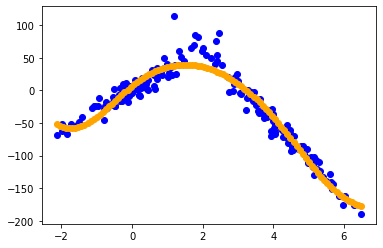

In [13]:
plt.scatter(X_train.X, y, color='blue')

xplot = np.linspace(X_train.X.min(), X_train.X.max(), 100)
yplot = fit.predict(dmatrix(FORMULA, {"train": xplot}, return_type='dataframe'))
plt.scatter(xplot, yplot, color='orange')

pred = fit.predict(dmatrix(FORMULA, {"train": X_train.X}, return_type='dataframe'))
print(f'RMSE = {mean_squared_error(pred, y) ** 0.5:.2f}')

# Natural Cubic Splines
* Use splines that have constraints (forces smoothness)
  * Polynomials must be continuous at the knot
  * Polynomials first and second derivative must be same at the knot


In [14]:
FORMULA = 'cr(train, df=6) -1'
X_cubic = dmatrix(FORMULA, {"train": X_train.X}, return_type='dataframe')
X_cubic.head()

,"cr(train, df=6)[0]","cr(train, df=6)[1]","cr(train, df=6)[2]","cr(train, df=6)[3]","cr(train, df=6)[4]","cr(train, df=6)[5]"
0,0.375760,0.919925,-0.320412,0.040665,-0.017205,0.001266
1,0.538060,0.707546,-0.266145,0.033778,-0.014291,0.001052
2,0.022028,-0.324695,0.982018,0.497245,-0.190625,0.014030
3,0.019374,1.057151,-0.082925,0.010524,-0.004453,0.000328
4,0.088670,1.124261,-0.230736,0.029284,-0.012390,0.000912


In [15]:
fit = sm.GLM(y, X_cubic).fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      194
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                          174.62
Method:                          IRLS   Log-Likelihood:                -797.00
Date:                Tue, 20 Jul 2021   Deviance:                       33876.
Time:                        19:51:02   Pearson chi2:                 3.39e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
cr(train, df=6)[0]   -57.0537      5

RMSE = 13.01


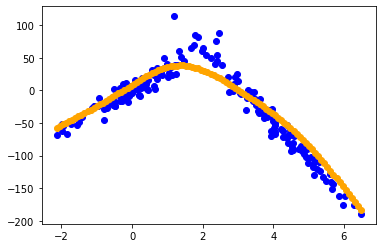

In [16]:
plt.scatter(X_train.X, y, color='blue')

xplot = np.linspace(X_train.X.min(), X_train.X.max(), 100)
yplot = fit.predict(dmatrix(FORMULA, {"train": xplot}, return_type='dataframe'))
plt.scatter(xplot, yplot, color='orange')

pred = fit.predict(dmatrix(FORMULA, {"train": X_train.X}, return_type='dataframe'))
print(f'RMSE = {mean_squared_error(pred, y) ** 0.5:.2f}')

# Piecewise Linear Fit
* Finds an optimal fit using the number of specified segments

In [17]:
SEGMENTS = 2
pw_lm = pwlf.PiecewiseLinFit(X[0], y)
breaks = pw_lm.fit(SEGMENTS)
print(breaks)

[-2.13171211  1.97647584  6.49102808]


/usr/local/lib/python3.7/dist-packages/pwlf/pwlf.py:1109: RuntimeWarning: invalid value encountered in double_scalars
  (self.fit_breaks[i+1]-self.fit_breaks[i])


RMSE = 11.47


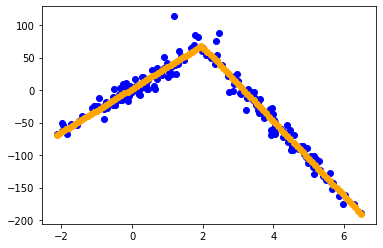

In [18]:
plt.scatter(X, y, color='blue')

xplot = np.linspace(X[0].min(), X[0].max(), 100)
yplot = pw_lm.predict(xplot)
plt.scatter(xplot, yplot, color='orange')

pred = pw_lm.predict(X[0])
print(f'RMSE = {mean_squared_error(pred, y) ** 0.5:.2f}')

# Numpy Piecewise
* Pair numpy piecewise with scipy optimize
* Finds the optimal value for a split
* Requires you to be involved in defining the formulation

In [19]:
def numpy_piecewise(x, x0, y0, w1, w2):
  return np.piecewise(x, [x < x0], [lambda x:w1 * x + y0 - w1 * x0, 
                                    lambda x:w2 * x + y0 - w2 * x0])
popt, pcov = optimize.curve_fit(numpy_piecewise, list(X[0]), y)
print(popt) # Optimized Values
print(pcov) # Covariance of Optimized Values

[  1.97647585  68.00776455  33.43829977 -57.27312847]
[[ 1.77558362e-03 -2.47371584e-02 -3.56326308e-02 -2.92945841e-02]
 [-2.47371584e-02  3.99005462e+00  2.04079225e+00 -9.79561124e-01]
 [-3.56326308e-02  2.04079225e+00  1.66562936e+00 -1.44516027e-08]
 [-2.92945841e-02 -9.79561124e-01 -1.44516024e-08  1.24972313e+00]]


RMSE = 11.47


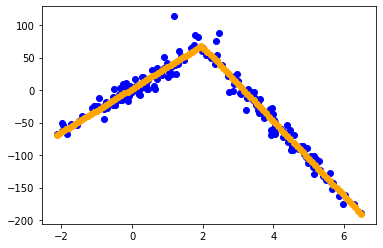

In [20]:
xplot = np.linspace(X.min(), X.max(), 100)
plt.scatter(X, y, color='blue')
plt.scatter(xplot, numpy_piecewise(xplot, *popt), color='orange')

pred = numpy_piecewise(list(X[0]), *popt)
print(f'RMSE = {mean_squared_error(pred, y) ** 0.5:.2f}')